In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import nltk
import re
import pickle
import string
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers.core import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow.keras.optimizers
from keras import regularizers
import seaborn as sns

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# PreProcess

In [ ]:
# Reading Data
cols = ['sentiment','id','date','query_string','user','text'] #Defining the columns
df = pd.read_csv("/content/drive/My Drive/tweets.csv",header=None, encoding = 'latin-1', names = cols)

In [ ]:
# Dropping unnecessary columns and converitng 4 label to 1 in order to ease
df.drop(columns = ['id','date','query_string','user'], axis=1, inplace=True)
df['sentiment'] = df['sentiment'].replace(4, 1)

In [ ]:
# check the number of positive vs. negative tagged sentences
positives = df['sentiment'][df.sentiment == 1 ]
negatives = df['sentiment'][df.sentiment == 0 ]

print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         1600000
No. of positve tagged sentences is:  800000
No. of negative tagged sentences is: 800000


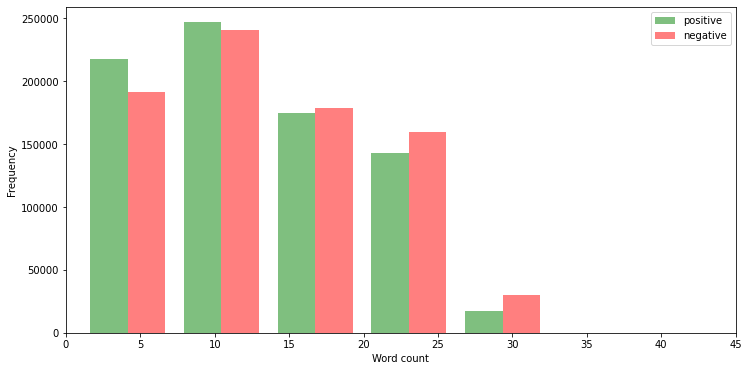

In [ ]:
def word_count(words):
    return len(words.split())

# plot word count distribution for both positive and negative 

df['word count'] = df['text'].apply(word_count)
p = df['word count'][df.sentiment == 1]
n = df['word count'][df.sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

## Cleaner function

In [ ]:
def tweet_cleaner(text):
  urlPattern = r'http://[^ ]*|https://[^ ]*|www\.[^ ]*'
  userPattern = '@[^\s]+'
  hashtag_number = '[#0-9]+'
  soup = BeautifulSoup(text, 'lxml')
  souped = soup.get_text()
  # Removing all URls 
  tweet = re.sub(urlPattern,'',str(souped).lower()).strip()
  # Removing all @username.
  tweet = re.sub(userPattern,'', tweet) 
  # Removing all hashtag-numbers.
  tweet = re.sub(hashtag_number,'', tweet) 
  tweet = re.sub('(?<=.)[\'](?=.)', ' ', tweet)
  tweet = re.sub('((?<=^)|(?<=\s)).((?=$)|(?=\s))', '', tweet)
  tweet = re.sub('([^ ]*)(\.com)', '', tweet)
  tweet = tweet.translate(str.maketrans("","",string.punctuation))
  #tokenizing words
  tokens = word_tokenize(tweet)
  #Removing Stop Words
  final_tokens = [w for w in tokens if w not in stopword]
  #reducing a word to its word stem 
  wordLemm = WordNetLemmatizer()
  finalwords=[]
  for w in final_tokens:
     if len(w)>1:
      word = wordLemm.lemmatize(w)
      finalwords.append(word)
  return ' '.join(finalwords)

In [ ]:
df['processed_tweets'] = df['text'].apply(tweet_cleaner)
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
df = df.drop(columns = ['text']).rename(columns = {'processed_tweets' : 'text'})

In [ ]:
#df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = '/content/drive/My Drive/clean_tweet.csv'
df = pd.read_csv(csv,index_col=0)
df.text = df.text.apply(lambda x: str(x))

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Some visualization

In [ ]:
all_words = []
for line in list(df['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('day', 104653),
 ('good', 89797),
 ('get', 86085),
 ('like', 79183),
 ('got', 69864),
 ('love', 67336),
 ('work', 66613),
 ('today', 66195),
 ('going', 64140),
 ('time', 64022),
 ('back', 56213),
 ('one', 56089),
 ('lol', 55344),
 ('know', 53412),
 ('really', 49588),
 ('want', 48314),
 ('see', 46135),
 ('night', 44154),
 ('think', 43536),
 ('still', 42868)]

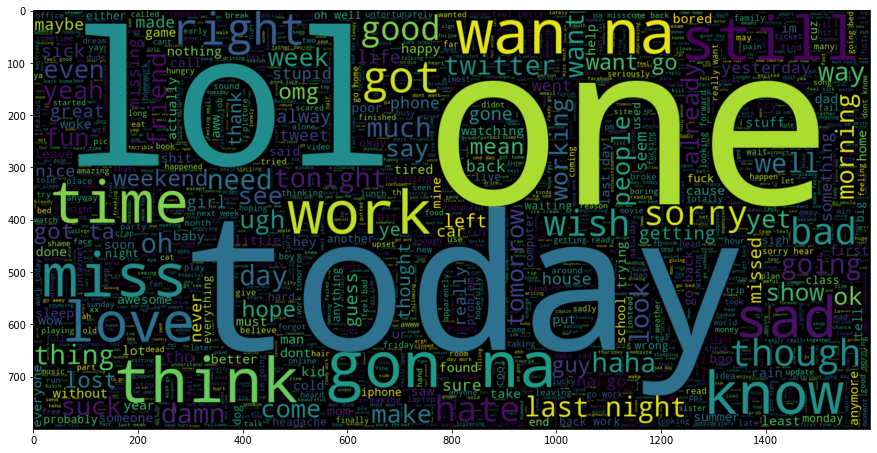

In [ ]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

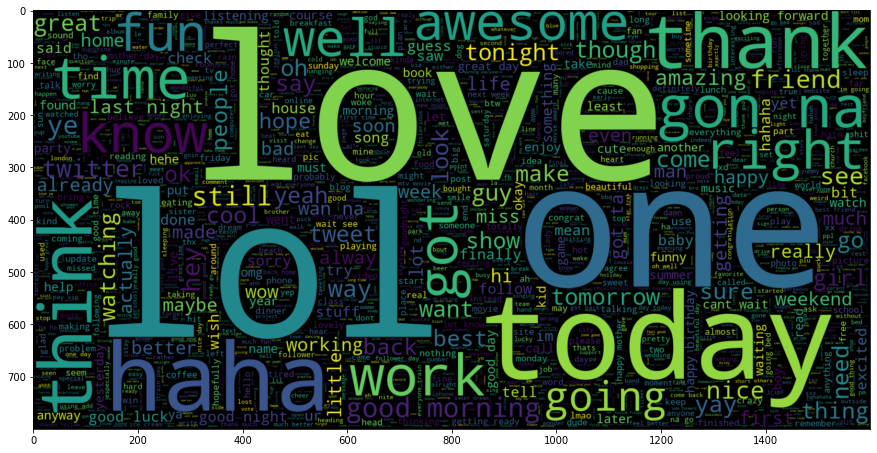

In [ ]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

## Tokenzing the tweets

In [ ]:
token = Tokenizer()
max_len = max(df.text.apply(lambda x: len(str(x).split())))
token.fit_on_texts(df.text)
sequence = token.texts_to_sequences(df.text)
tweet = pad_sequences(sequence, maxlen=max_len)

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    tokenizer = pickle.dump(token, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
tweet.shape

(1600000, 40)

## Splitting Train and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweet, df.sentiment.values, test_size=0.2, random_state=101)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train , test_size=0.2, random_state=101)

# Creating network (One sided lstm) 

## Loading glove weights

In [ ]:
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r',encoding="utf-8")
    lines = file.readlines()
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    mean = np.mean(np.array(list(embedding.values())), axis=0)
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, embedding_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
        else : 
            weight_matrix[i] = mean
    return weight_matrix

# contains the index for each word
vocab = token.word_index
# total number of words in our vocabulary, plus one for unknown words
vocab_size = len(token.word_index) + 1
# embedding dimensions
embedding_dim = 300

# load embedding from file
raw_embedding = load_embedding('/content/drive/My Drive/glove.42B.300d.txt')
# get vectors in the right order
embedding_matrix = get_weight_matrix(raw_embedding, vocab)

## Create Embedding Layer

In [ ]:
# create the embedding layer
embedding_layer = Embedding(vocab_size, 
                            embedding_dim, 
                            weights = [embedding_matrix], 
                            input_length = max_len, 
                            trainable = False)

## Creating the model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(150))
model.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(1e-2)))
model.add(Dense(1, activation = "sigmoid"))

optimizer = tensorflow.keras.optimizers.Adam()

model.compile(optimizer= optimizer,loss='binary_crossentropy', metrics=['acc'])

#Call backs
checkpoint = ModelCheckpoint("rnn_model.hdf5", monitor='val_acc', verbose=1,save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2,
                              min_lr = 0.0001)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           115936200 
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 3)                 453       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 116,207,257
Trainable params: 271,057
Non-trainable params: 115,936,200
_________________________________________________________________


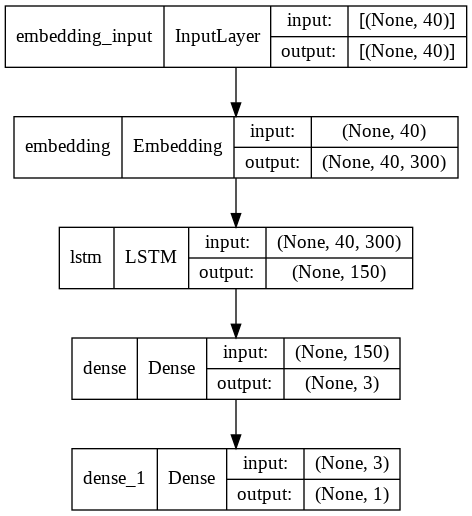

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model3.png')
from IPython.display import Image
Image(retina=True, filename='model3.png')

## Training Netowrk

In [ ]:
history = model.fit(X_train, y_train, epochs=10,batch_size=1024,validation_data=(X_valid, y_valid), callbacks=[checkpoint, reduce_lr])

Streaming output truncated to the last 5000 lines.
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4251 - acc: 0.8041 - val_loss: 0.4505 - val_acc: 0.7885 - lr: 0.0010
Epoch 7/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4165 - acc: 0.8087 - val_loss: 0.4489 - val_acc: 0.7912 - lr: 0.0010
Epoch 8/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.4080 - acc: 0.8139 - val_loss: 0.4503 - val_acc: 0.7912 - lr: 0.0010
Epoch 9/10
1000/1000 [==============================] - 72s 72ms/step - loss: 0.3995 - acc: 0.8186 - val_loss: 0.4524 - val_acc: 0.7894 - lr: 0.0010
Epoch 10/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.3910 - acc: 0.8238 - val_loss: 0.4542 - val_acc: 0.7882 - lr: 0.0010


## Evaluating model

In [11]:
def model_Evaluate(model):
    #accuracy of model on training data
    loss_train ,acc_train= model.evaluate(X_train, y_train, batch_size=1024)
    #accuracy of model on validation data
    loss_valid ,acc_valid = model.evaluate(X_valid, y_valid, batch_size=1024)
    #accuracy of model on test data
    loss_test ,acc_test = model.evaluate(X_test, y_test, batch_size=1024)
    
    print(f'Accuracy and loss of model on training data : {acc_train:.2f}, {loss_train:.2f}')
    print(f'Accuracy and loss of model on validation data : {acc_valid:.2f}, {loss_valid:.2f}')
    print(f'Accuracy and loss of model on test data : {acc_test:.2f}, {loss_test:.2f}')

    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_pred[y_pred>= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

313/313 [==============================] - 7s 21ms/step - loss: 0.4569 - acc: 0.7868
Accuracy and loss of model on training data : 0.83, 0.38
Accuracy and loss of model on validation data : 0.79, 0.45
Accuracy and loss of model on test data : 0.79, 0.46
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    159763
           1       0.79      0.79      0.79    160237

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



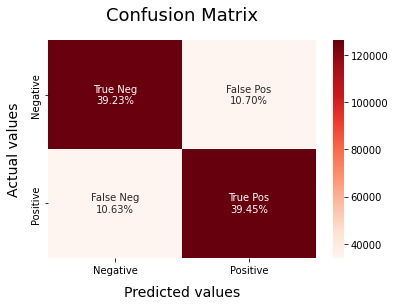

In [12]:
model_Evaluate(model)

### Plots

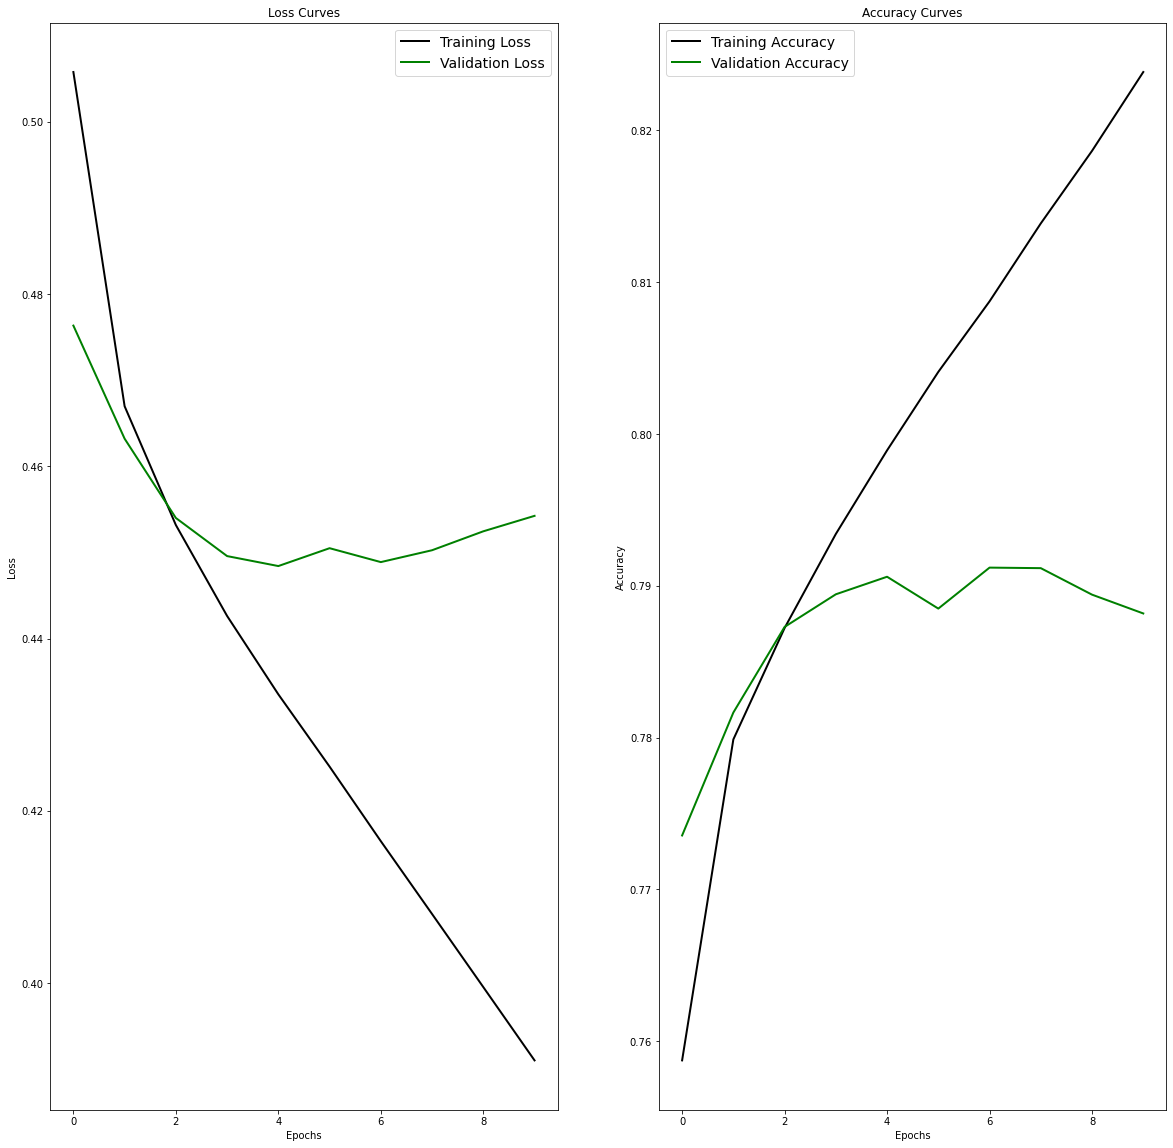

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (20, 20))
ax[0].plot(history.history['loss'], 'black', linewidth=2.0)
ax[0].plot(history.history['val_loss'], 'green', linewidth=2.0)
ax[0].legend(['Training Loss', 'Validation Loss'], fontsize=14)
ax[0].set(xlabel= 'Epochs'
            , ylabel= 'Loss'
            , title= 'Loss Curves');
ax[1].plot(history.history['acc'], 'black', linewidth=2.0)
ax[1].plot(history.history['val_acc'], 'green', linewidth=2.0)
ax[1].legend(['Training Accuracy' , 'Validation Accuracy'], fontsize=14)
ax[1].set(xlabel= 'Epochs'
            , ylabel= 'Accuracy'
            , title= 'Accuracy Curves');

# Creting Network (Bidirectional lstm)

In [14]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(150)))
model2.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(1e-2)))
model2.add(Dense(1, activation = "sigmoid"))

optimizer = tensorflow.keras.optimizers.Adam()

model2.compile(optimizer= optimizer,loss='binary_crossentropy', metrics=['acc'])

In [15]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           115936200 
                                                                 
 bidirectional (Bidirectiona  (None, 300)              541200    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 903       
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 116,478,307
Trainable params: 542,107
Non-trainable params: 115,936,200
_________________________________________________________________


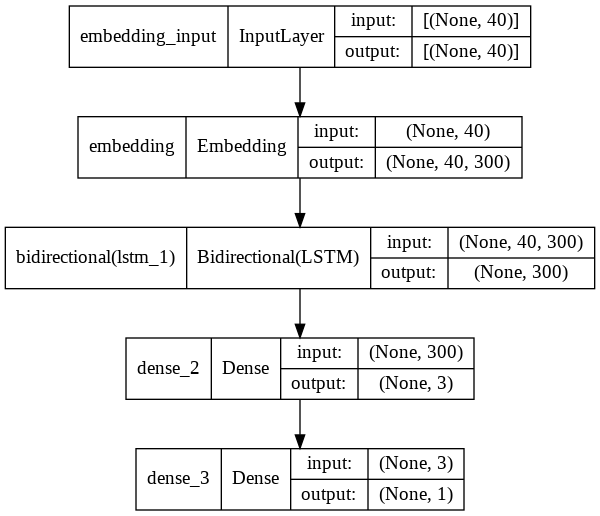

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model3.png')
from IPython.display import Image
Image(retina=True, filename='model3.png')

## Training Netowrk

In [17]:
history2 = model2.fit(X_train, y_train, epochs=10,batch_size=1024,validation_data=(X_valid, y_valid), callbacks=[checkpoint, reduce_lr])

Streaming output truncated to the last 5000 lines.
1000/1000 [==============================] - 131s 131ms/step - loss: 0.4121 - acc: 0.8107 - val_loss: 0.4471 - val_acc: 0.7897 - lr: 0.0010
Epoch 7/10
1000/1000 [==============================] - 130s 130ms/step - loss: 0.4004 - acc: 0.8175 - val_loss: 0.4513 - val_acc: 0.7907 - lr: 0.0010
Epoch 8/10
1000/1000 [==============================] - 132s 132ms/step - loss: 0.3910 - acc: 0.8230 - val_loss: 0.4514 - val_acc: 0.7895 - lr: 0.0010
Epoch 9/10
1000/1000 [==============================] - 130s 130ms/step - loss: 0.3756 - acc: 0.8320 - val_loss: 0.4569 - val_acc: 0.7892 - lr: 0.0010
Epoch 10/10
1000/1000 [==============================] - 130s 130ms/step - loss: 0.3633 - acc: 0.8391 - val_loss: 0.4664 - val_acc: 0.7861 - lr: 0.0010


## Evaluating model

313/313 [==============================] - 13s 39ms/step - loss: 0.4678 - acc: 0.7853
Accuracy and loss of model on training data : 0.85, 0.34
Accuracy and loss of model on validation data : 0.79, 0.47
Accuracy and loss of model on test data : 0.79, 0.47
              precision    recall  f1-score   support

           0       0.79      0.78      0.78    159763
           1       0.78      0.79      0.79    160237

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



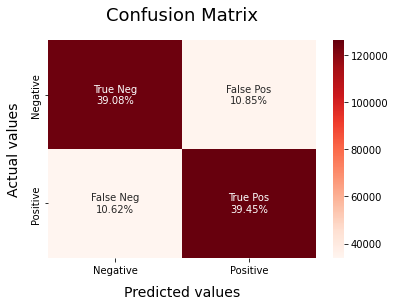

In [18]:
model_Evaluate(model2)

### plots

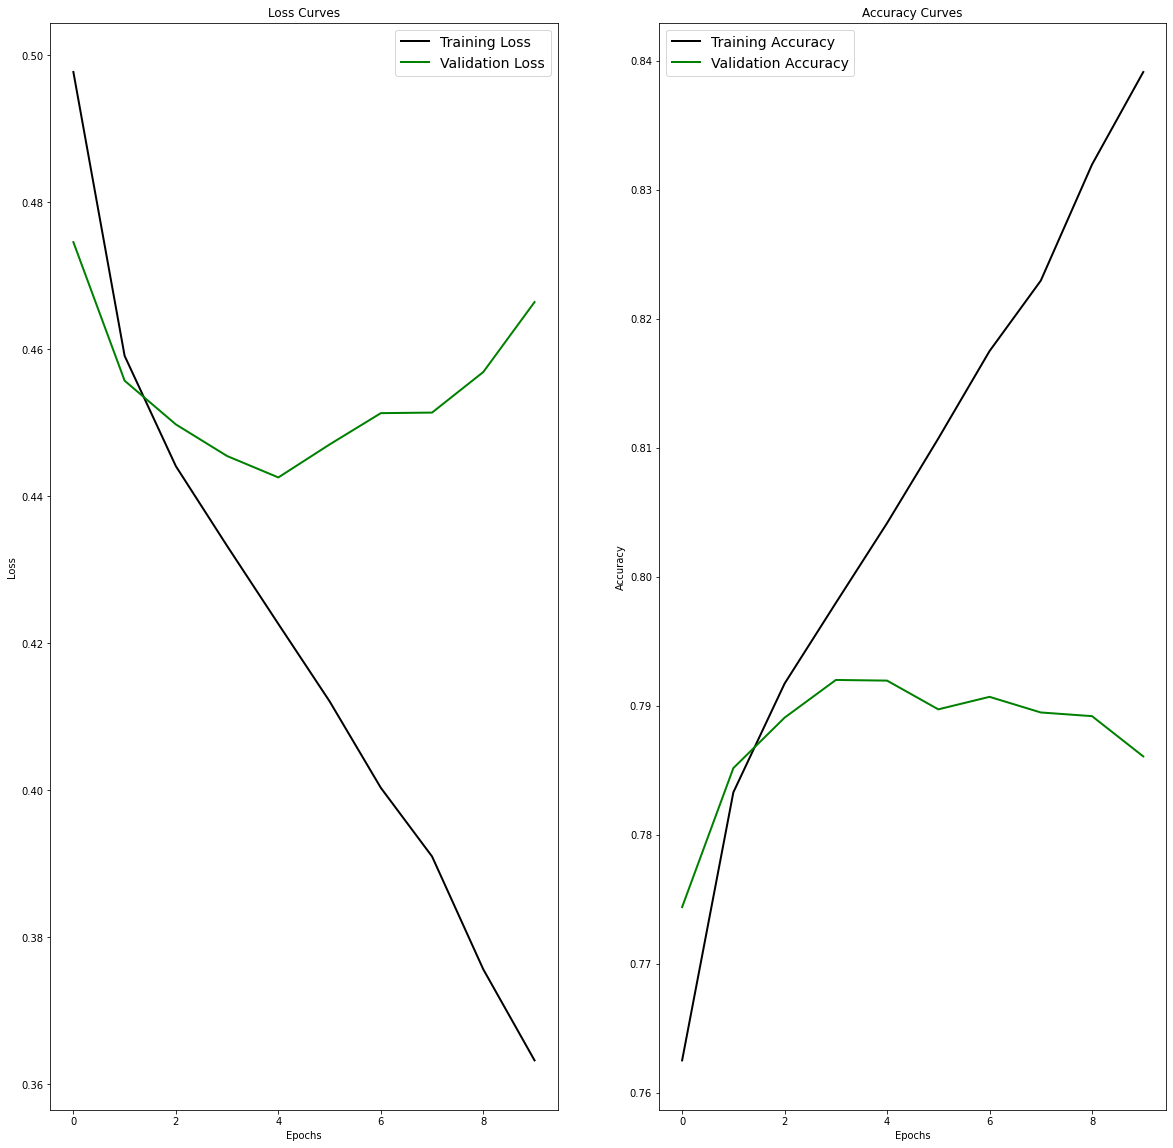

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (20, 20))
ax[0].plot(history2.history['loss'], 'black', linewidth=2.0)
ax[0].plot(history2.history['val_loss'], 'green', linewidth=2.0)
ax[0].legend(['Training Loss', 'Validation Loss'], fontsize=14)
ax[0].set(xlabel= 'Epochs'
            , ylabel= 'Loss'
            , title= 'Loss Curves');
ax[1].plot(history2.history['acc'], 'black', linewidth=2.0)
ax[1].plot(history2.history['val_acc'], 'green', linewidth=2.0)
ax[1].legend(['Training Accuracy' , 'Validation Accuracy'], fontsize=14)
ax[1].set(xlabel= 'Epochs'
            , ylabel= 'Accuracy'
            , title= 'Accuracy Curves');

# Creating network(Bidirectional lstm with dropout)

In [21]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.3))
model3.add(Bidirectional(LSTM(150, dropout=0.3)))
model3.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(1e-2)))
model3.add(Dense(1, activation = "sigmoid"))

optimizer = tensorflow.keras.optimizers.Adam()

model3.compile(optimizer= optimizer,loss='binary_crossentropy', metrics=['acc'])

In [22]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           115936200 
                                                                 
 dropout_1 (Dropout)         (None, 40, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 903       
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 116,478,307
Trainable params: 542,107
Non-trainable params: 115,936,200
__________________________________

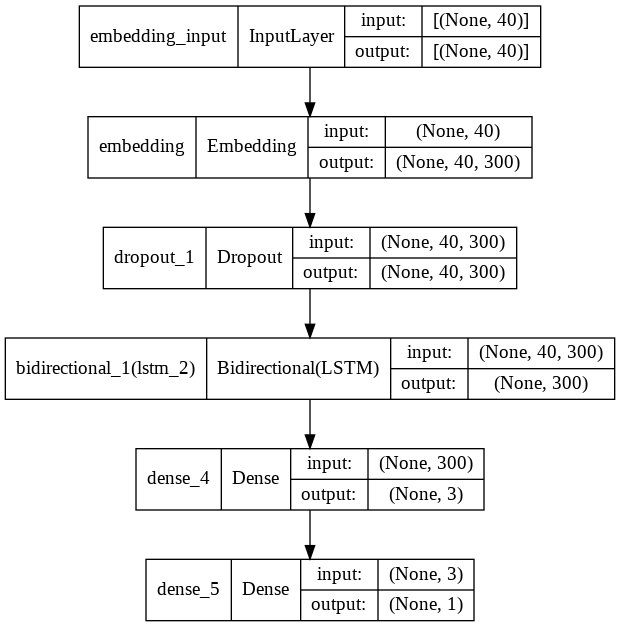

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model3.png')
from IPython.display import Image
Image(retina=True, filename='model3.png')

## Training Netowrk

In [24]:
history3 = model3.fit(X_train, y_train, epochs=10,batch_size=1024,validation_data=(X_valid, y_valid), callbacks=[checkpoint, reduce_lr])

Streaming output truncated to the last 5000 lines.
1000/1000 [==============================] - 139s 139ms/step - loss: 0.4586 - acc: 0.7818 - val_loss: 0.4448 - val_acc: 0.7917 - lr: 0.0010
Epoch 7/10
1000/1000 [==============================] - 141s 141ms/step - loss: 0.4547 - acc: 0.7843 - val_loss: 0.4484 - val_acc: 0.7913 - lr: 0.0010
Epoch 8/10
1000/1000 [==============================] - 139s 139ms/step - loss: 0.4511 - acc: 0.7863 - val_loss: 0.4460 - val_acc: 0.7936 - lr: 0.0010
Epoch 9/10
1000/1000 [==============================] - 140s 141ms/step - loss: 0.4487 - acc: 0.7876 - val_loss: 0.4426 - val_acc: 0.7949 - lr: 0.0010
Epoch 10/10
1000/1000 [==============================] - 141s 141ms/step - loss: 0.4461 - acc: 0.7895 - val_loss: 0.4434 - val_acc: 0.7946 - lr: 0.0010


## Evaluating model

313/313 [==============================] - 13s 39ms/step - loss: 0.4459 - acc: 0.7928
Accuracy and loss of model on training data : 0.81, 0.42
Accuracy and loss of model on validation data : 0.79, 0.44
Accuracy and loss of model on test data : 0.79, 0.45
              precision    recall  f1-score   support

           0       0.78      0.81      0.80    159763
           1       0.80      0.78      0.79    160237

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



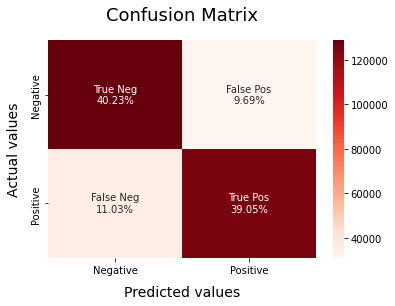

In [25]:
model_Evaluate(model3)

### plots

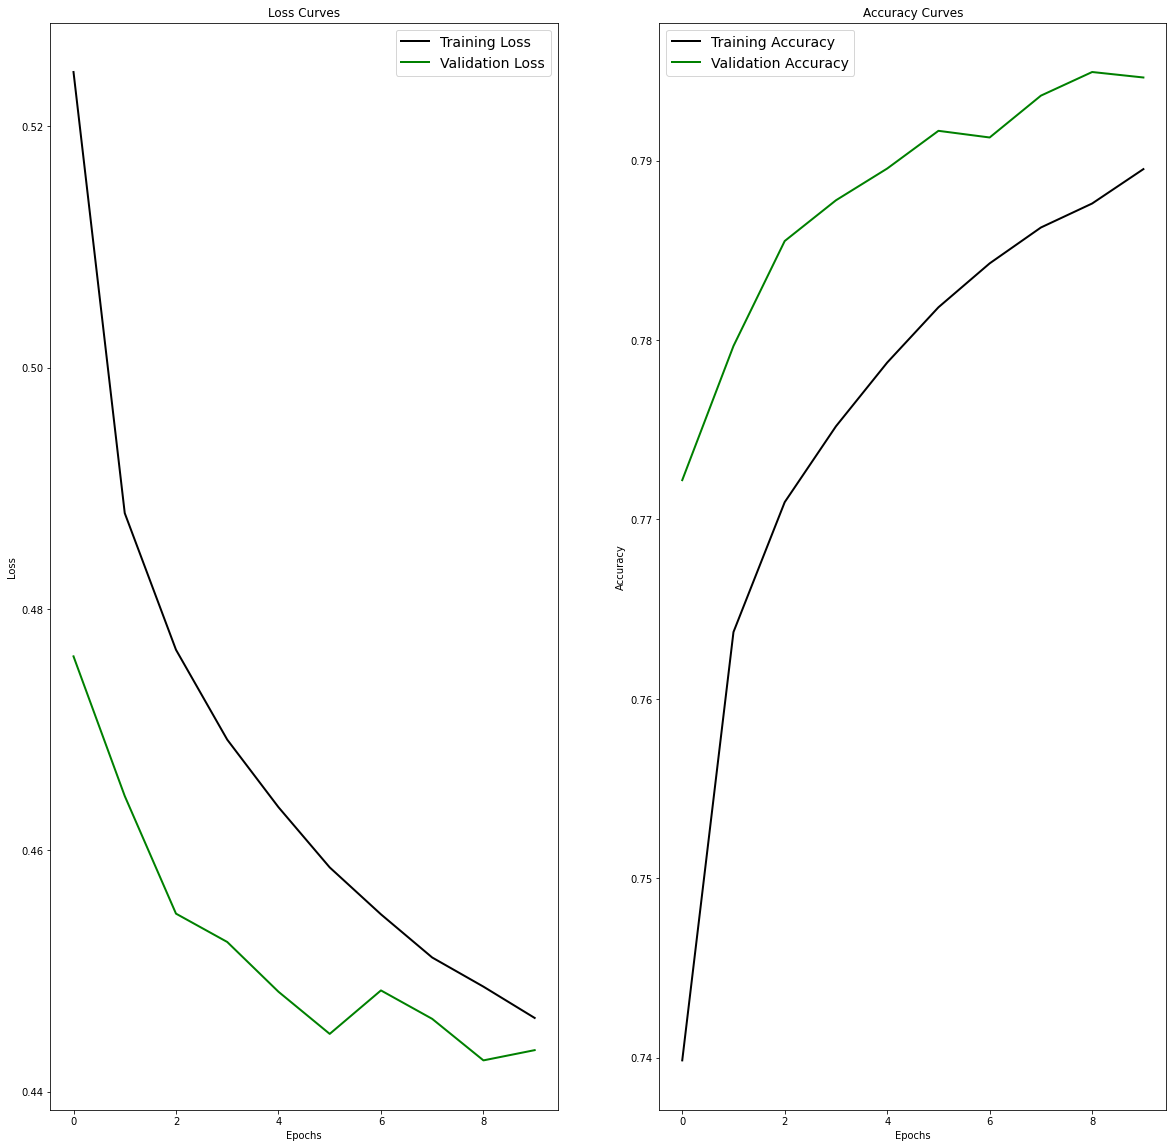

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (20, 20))
ax[0].plot(history3.history['loss'], 'black', linewidth=2.0)
ax[0].plot(history3.history['val_loss'], 'green', linewidth=2.0)
ax[0].legend(['Training Loss', 'Validation Loss'], fontsize=14)
ax[0].set(xlabel= 'Epochs'
            , ylabel= 'Loss'
            , title= 'Loss Curves');
ax[1].plot(history3.history['acc'], 'black', linewidth=2.0)
ax[1].plot(history3.history['val_acc'], 'green', linewidth=2.0)
ax[1].legend(['Training Accuracy' , 'Validation Accuracy'], fontsize=14)
ax[1].set(xlabel= 'Epochs'
            , ylabel= 'Accuracy'
            , title= 'Accuracy Curves');